## 1. PREPROCESSING ##

In [2]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

In [3]:
import pandas as pd
#read in data
df=pd.read_csv('data/parkinsons_updrsdata.csv')

In [4]:
# choose total_UPDRS as my target variable
y = df[['total_UPDRS']]
#y = np.ravel(y)
X = df.drop(['test_time','total_UPDRS','motor_UPDRS', 'Jitter:RAP', 'Shimmer:APQ3'], axis=1) # drop because of high correlation
X = pd.DataFrame(X)
y = pd.DataFrame(y)
print(X.shape)

(5875, 17)


In [5]:
##preprocessor # min max and std
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
minmax_ftrs = ['age']
std_ftrs = ['Jitter(%)', 'Jitter(Abs)','Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ5','Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
cat_ftrs =['sex']

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

In [6]:
## param grid
ridge_param_grid = {
    'ridge__alpha': [5, 10], 
    'ridge__max_iter': [1000], 
}

lasso_param_grid = {
    'lasso__alpha': [5, 10],  
    'lasso__max_iter': [1000] 
}

svr_param_grid = {
    'svr__C': [1, 10, 20, 30, 50, 100], 
    'svr__epsilon': [0.1, 0.01, 0.001]  
}

rf_param_grid = {
    'randomforestregressor__n_estimators': [50, 40, 30],
    'randomforestregressor__max_depth': [1, 2, 3, 4], 
}


knn_param_grid = {
    'kneighborsregressor__n_neighbors': [250,280,290,500,1000],
    'kneighborsregressor__weights': ['uniform'],
    'kneighborsregressor__p': [1, 2, 3]
}

xgb_param_grid = {
    'xgbregressor__n_estimators': [1, 27],
    'xgbregressor__max_depth': [1], 
    'xgbregressor__learning_rate': [ 0.1]
}


## 2. CREATE PIPELINE ##

In [7]:
#model to train
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
models = {
    "Linear Regression with L1 Regularization (Lasso)": (Lasso(), lasso_param_grid),
    "Linear Regression with L2 Regularization (Ridge)": (Ridge(), ridge_param_grid),
    #"Random Forest (RF)": (RandomForestRegressor(), rf_param_grid),
    #"Support Vector Regression (SVR)": (SVR(), svr_param_grid),
    "K-Nearest Neighbor Regression (KNN)": (KNeighborsRegressor(), knn_param_grid),
    "XGBoost Resgressor (XGB)": (XGBRegressor(), xgb_param_grid)
}

In [8]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

def rmse_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)


In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#create function where loop through 10 random states, split data based on subject, fit the models, calculate test and baseline score

def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
    
    test_scores = []
    baseline_rmse_scores = []
    best_models = []
    final_models = []

    for random_state in range(10):
        print(f"Random State: {random_state}")
        
        np.random.seed(random_state)

        groups = df['subject#']
        # set out 20% of all data for the test set
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
        for i_other, i_test in splitter.split(X, y, groups=groups):
            X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
            X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
            
        X_other = X_other.drop(columns=['subject#'])
        X_test = X_test.drop(columns=['subject#'])


        
        # Check if ML_algo is RandomForestRegressor or RandomForestClassifier
        if isinstance(ML_algo, (RandomForestRegressor, SVR)):
            y_other = np.ravel(y_other)  # Ravel the target variable if it's a RandomForest

        # Initialize KFold with 4 folds
        kf = GroupKFold(n_splits=4)

        pipe = make_pipeline(preprocessor, ML_algo)
        #this is used for calculating ridge model coeficient
        #final_scaler=StandScaler()
        #pipe = make_pipeline(preprocessor,final_scaler, ML_algo)

        #grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=kf, scoring=rmse_scorer, n_jobs=-1)

        grid_search.fit(X_other, y_other, groups=groups_other)

        # Find the best model from cross-validation
        final_model = grid_search.best_estimator_
        final_models.append(final_model)

        best_model = grid_search.best_params_
        best_models.append(best_model)

        # Calculate RMSE on the test set
        y_test_pred = final_model.predict(X_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_scores.append(test_rmse)

        #calculate rmse on the baseline
        mean_baseline = np.mean(y_other)
        baseline_predictions = np.full_like(y_test, mean_baseline)
        baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_predictions))
        baseline_rmse_scores.append(baseline_rmse)

        print(f"Test RMSE: {test_rmse}")
        print(f"Basline RMSE: {baseline_rmse}")

    return test_scores, best_models, final_models, baseline_rmse_scores

In [10]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# set up evaluation & loop through
def train_and_evaluate_models_with_baseline(models, X, y, preprocessor, groups):
    results = {}

    for model_name, (model, param_grid) in models.items():
        print(f"Training and evaluating {model_name}...")
        
        # Call MLpipe_KFold_RMSE
        test_scores, best_models,final_models, baseline_rmse_scores = MLpipe_KFold_RMSE(X, y, preprocessor, model, param_grid)
        
        mean_test_score = np.mean(test_scores)
        std_test_score = np.std(test_scores)

        mean_baseline_rmse = np.mean(baseline_rmse_scores)
        std_baseline_rmse = np.std(baseline_rmse_scores)
        
        results[model_name] = {
            'mean_test_score': mean_test_score,
            'std_test_score': std_test_score,
            'mean_baseline_rmse': mean_baseline_rmse,
            'std_baseline_rmse': std_baseline_rmse,
            'best_models': best_models,
            'final_models':final_models
        }
        
        print(f"{model_name} Mean Test RMSE: {mean_test_score:.2f} (Std Dev: {std_test_score:.2f})")
        print(f"{model_name} Mean Baseline RMSE: {mean_baseline_rmse:.2f} (Std Dev: {std_baseline_rmse:.2f})\n")
    
    return results

## 3. STORE RESULTS ##

In [11]:
# store the results of the models
groups = df['subject#']
results = train_and_evaluate_models_with_baseline(models, X, y, preprocessor, groups)

Training and evaluating Linear Regression with L1 Regularization (Lasso)...
Random State: 0
Test RMSE: 8.037329032157544
Basline RMSE: 8.037329032157544
Random State: 1
Test RMSE: 12.014360181822097
Basline RMSE: 12.014360181822097
Random State: 2
Test RMSE: 10.957003519763825
Basline RMSE: 10.957003519763825
Random State: 3
Test RMSE: 10.897900171749706
Basline RMSE: 10.897900171749706
Random State: 4
Test RMSE: 8.994077119262842
Basline RMSE: 8.994077119262842
Random State: 5
Test RMSE: 11.174844383264954
Basline RMSE: 11.174844383264954
Random State: 6
Test RMSE: 10.01937272607386
Basline RMSE: 10.01937272607386
Random State: 7
Test RMSE: 14.211853533331329
Basline RMSE: 14.211853533331329
Random State: 8
Test RMSE: 10.063550661492231
Basline RMSE: 10.063550661492231
Random State: 9
Test RMSE: 12.004128706922074
Basline RMSE: 12.004128706922074
Linear Regression with L1 Regularization (Lasso) Mean Test RMSE: 10.84 (Std Dev: 1.64)
Linear Regression with L1 Regularization (Lasso) Mean

In [13]:
results

{'Linear Regression with L1 Regularization (Lasso)': {'mean_test_score': 10.837442003584046,
  'std_test_score': 1.6362001664783565,
  'mean_baseline_rmse': 10.837442003584046,
  'std_baseline_rmse': 1.6362001664783565,
  'best_models': [{'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000},
   {'lasso__alpha': 5, 'lasso__max_iter': 1000}],
  'final_models': [Pipeline(steps=[('columntransformer',
                    ColumnTransformer(transformers=[('minmax', MinMaxScaler(),
                                                     ['age']),
                                                    ('std', StandardScaler(

## 4. PERFORMANCE VISUALIZATION ##

In [14]:
#Summarize the performance of the ML models in a table or using a figure. 

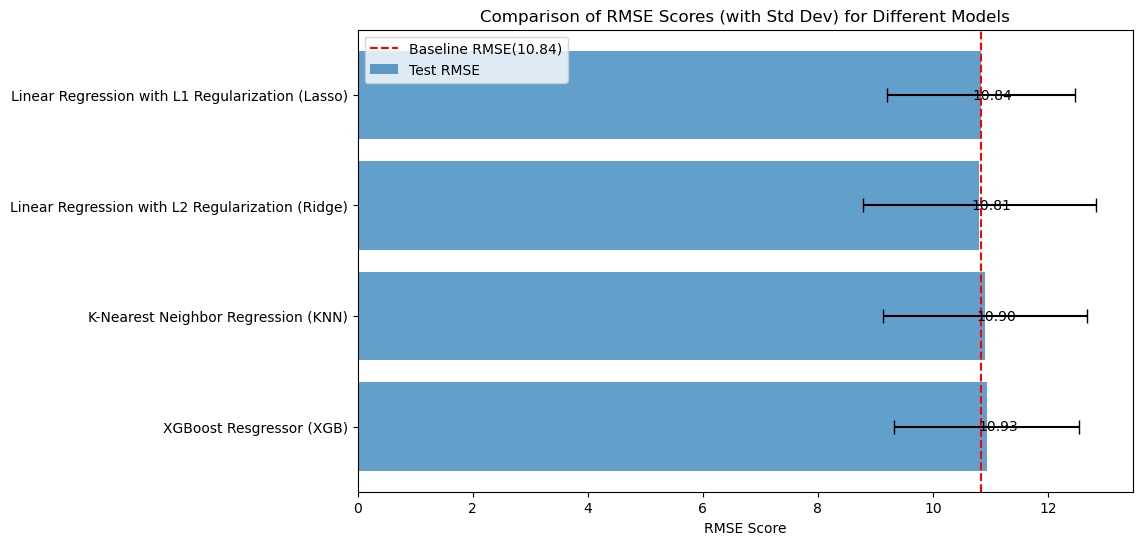

In [17]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(results.keys())
mean_test_rmse = [results[model]['mean_test_score'] for model in model_names]
std_test_rmse = [results[model]['std_test_score'] for model in model_names]

# Create a bar chart to compare mean test RMSE with error bars for std test RMSE
plt.figure(figsize=(10, 6))
bars = plt.barh(model_names, mean_test_rmse, xerr=std_test_rmse, label='Test RMSE', alpha=0.7, capsize=5)

# Add a horizontal line at 10.79 (the baseline RMSE)
plt.axvline(x=10.84, color='red', linestyle='--', label='Baseline RMSE(10.84)')

# Add labels and a legend
plt.xlabel('RMSE Score')
plt.title('Comparison of RMSE Scores (with Std Dev) for Different Models')
plt.legend()

# Show the plot
plt.gca().invert_yaxis()

# Annotate each bar with its RMSE value
for bar, rmse in zip(bars, mean_test_rmse):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2, f'{rmse:.2f}', ha='center', va='center')

plt.savefig('total_UPDRS.png', dpi=600, bbox_inches='tight')

plt.savefig('Comparison_of_RMSE_Scores_with_Std_Dev_for_Different_Models.png', dpi=600)
plt.show()


## 5. interpreterability for the ridge model ##

**global 1: perputation** 

In [14]:
splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=0) 
for i_other, i_test in splitter.split(X, y, groups=groups): 
        X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
        X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

X_other = X_other.drop(columns=['subject#'])
X_test = X_test.drop(columns=['subject#'])

#perform k fold split on the rest of data to get train & val
n=0
kfold = GroupKFold(n_splits=4)
for train_index, test_index in kfold.split(X_other, y_other, groups=groups_other):
    n=n+1
    X_train, X_val = X_other.iloc[train_index],  X_other.iloc[test_index]
    y_train, y_val = y_other.iloc[train_index], y_other.iloc[test_index]
    
    X_train_scaled=X_train.copy()
    X_val_scaled=X_val.copy()
    X_test_scaled=X_test.copy()
    
    scaler = StandardScaler()
    cols= ['Jitter(%)', 'Jitter(Abs)','Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ5','Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']     
    for col in cols:
        X_train_scaled[col]=scaler.fit_transform(pd.DataFrame(X_train[col]))
        X_val_scaled[col]=scaler.transform(pd.DataFrame(X_val[col]))
        X_test_scaled[col]=scaler.transform(pd.DataFrame(X_test[col]))
    
    scaler = MinMaxScaler()
    X_train_scaled['age'] = scaler.fit_transform(pd.DataFrame(X_train['age']))
    X_val_scaled['age'] = scaler.transform(pd.DataFrame(X_val['age']))
    X_test_scaled['age'] = scaler.transform(pd.DataFrame(X_test['age']))

    
    encoder = OneHotEncoder()

    # Fit and transform the 'sex' column for the training set
    X_train_sex_encoded = encoder.fit_transform(pd.DataFrame(X_train['sex'].values.reshape(-1, 1)))
    
    # Transform the 'sex' column for the validation and test sets
    X_val_sex_encoded = encoder.transform(pd.DataFrame(X_val['sex'].values.reshape(-1, 1)))
    X_test_sex_encoded = encoder.transform(pd.DataFrame(X_test['sex'].values.reshape(-1, 1)))
    
    # Create DataFrame with one-hot encoded 'sex' column
    X_train_encoded = pd.concat([X_train_scaled, pd.DataFrame(X_train_sex_encoded)], axis=1)
    X_val_encoded = pd.concat([X_val_scaled, pd.DataFrame(X_val_sex_encoded)], axis=1)
    X_test_encoded = pd.concat([X_test_scaled, pd.DataFrame(X_test_sex_encoded)], axis=1)

In [15]:
ridge_model = results["Linear Regression with L2 Regularization (Ridge)"]["final_models"][0]
ridge_estimator = ridge_model.named_steps["ridge"]

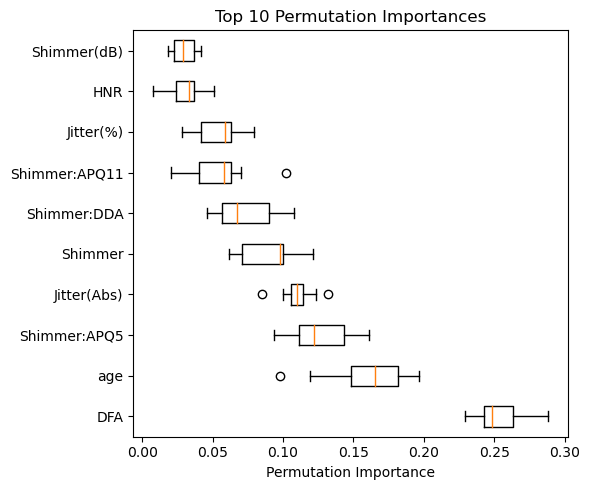

In [16]:
# Perputation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

##random state set to 0
# Calculate permutation importance on the test set
result = permutation_importance(ridge_model, X_test, y_test, n_repeats=10, random_state=0)

# Get feature importances and their indices
feature_importance = result.importances_mean
feature_indices = np.argsort(feature_importance)[::-1]

# Select the top 10 most important features
top_n = 10
top_feature_indices = feature_indices[:top_n]
top_feature_names = X_test.columns[top_feature_indices]
top_feature_importance = feature_importance[top_feature_indices]

# Create a box plot to visualize feature importances
plt.figure(figsize=(6, 5))
plt.boxplot(result.importances[top_feature_indices].T, vert=False)
plt.yticks(range(1, top_n + 1), top_feature_names)
plt.xlabel('Permutation Importance')
plt.title('Top 10 Permutation Importances')
plt.tight_layout()
plt.savefig('Top 10 Permutation Importances', dpi=300) 
plt.show()

**global 2 shap** 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


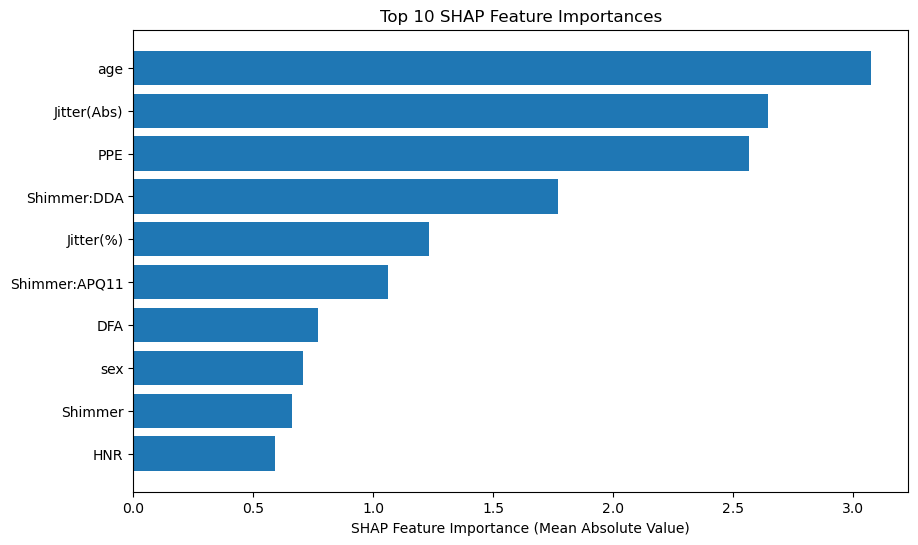

In [17]:
import shap
ridge = Ridge(alpha=10, max_iter=1000)
ridge.fit(X_train_scaled, y_train)

def model_wrapper(X):
    return ridge.predict(X)

explainer = shap.Explainer(model_wrapper, X_train_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)
global_importance = np.abs(shap_values).mean(axis=0)
feature_names = X_test.columns

sorted_indices = np.argsort(global_importance)[::-1]
top_n = 10

# Select the top 10 most important features and their corresponding importance values
top_feature_indices = sorted_indices[:top_n]
top_feature_names = [feature_names[i] for i in top_feature_indices]
top_feature_importance = global_importance[top_feature_indices]

# Create a bar chart for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_feature_importance, align='center')
plt.yticks(range(top_n), top_feature_names)
plt.xlabel('SHAP Feature Importance (Mean Absolute Value)')
plt.title('Top 10 SHAP Feature Importances')
plt.gca().invert_yaxis()
plt.savefig('Top 10 SHAP Feature Importances', dpi=300) 
plt.show()


**global 3 coefficient**

In [18]:
ridge_model = results["Linear Regression with L2 Regularization (Ridge)"]["final_models"][0]
ridge_estimator = ridge_model.named_steps["ridge"]
#X_train_encoded.columns #17
#ridge_est = ridge_estimator.coef_ #(17)
# this requires re-run the ridge model with standardization!!!!!!!

In [19]:
ridge_est= [3.00293288,  3.43337053, -4.05862336, -2.00470043,  0.50631301,2.48292997, -0.90867861, -2.50745098,  2.01818893, -2.58516831, 0.44671817, -2.05365949,  0.13814693, -2.16164757,  3.02381649, 1.30622529]
feature = ['age','Jitter(%)','Jitter(Abs)','Jitter:PPQ5', 'Jitter:DDP',  'Shimmer', 'Shimmer(dB)','Shimmer:APQ5', 'Shimmer:APQ11',   'Shimmer:DDA', 'NHR','HNR', 'RPDE', 'DFA', 'PPE','sex']

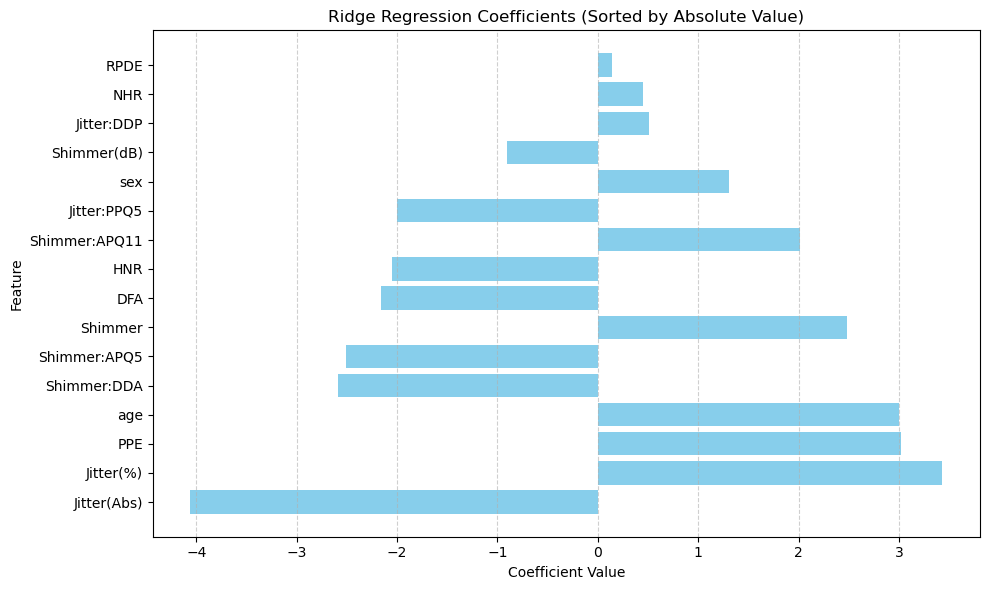

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Your feature names and corresponding coefficients
feature = ['age', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex']
ridge_est = [3.00293288,  3.43337053, -4.05862336, -2.00470043,  0.50631301,2.48292997, -0.90867861, -2.50745098,  2.01818893, -2.58516831, 0.44671817, -2.05365949,  0.13814693, -2.16164757,  3.02381649, 1.30622529]
# Sort coefficients by absolute value
sorted_indices = np.argsort(np.abs(ridge_est))[::-1]
sorted_feature = [feature[i] for i in sorted_indices]
sorted_coefficients = [ridge_est[i] for i in sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Ridge Regression Coefficients (Sorted by Absolute Value)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Ridge Regression Coefficients (Sorted by Absolute Value)', dpi=300) 
# Show the plot
plt.show()


**local** 

In [1]:
import shap

# Initialize SHAP for JavaScript plots
shap.initjs()

# Calculate the base value
base_value = model_wrapper(X_train_scaled).mean()

# Define a function to format the data point values to two decimal places
def format_data_point(data_point):
    return data_point.round(2)

# Selecting the first three data points from the test set
data_points_indices = [0, 200, 400]

# Generating and displaying force plots for each selected data point
for i in data_points_indices:
    data_point = X_test.iloc[i]
    formatted_data_point = format_data_point(data_point)  # Apply formatting
    shap_value = shap_values[i]

    # Display the force plot for the selected data point
    plot = shap.force_plot(
        base_value=base_value, 
        shap_values=shap_value, 
        features=formatted_data_point, 
        feature_names=X_test.columns.tolist(),
        matplotlib=True
    )
    
    # Save the force plot with a unique filename and DPI
    filename = f'force_plot_data_point_{i}.png'
    plt.savefig(filename, dpi=400)
     # Display the plot
    plt.show()


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


NameError: name 'model_wrapper' is not defined